# USMAN2024 CNN Architecture 
This notebook replicates the methodology from Usman2024 paper.
- Loads the KAIST Dataset
- Implements feature extraction based on FFT
- Builds the CNN Architecture, training and testing the model with different domains

## Load Data
The KAIST Dataset (Jung2022) has 4 sensed variables: acoustic, current, temperature, and vibration. In this case, only vibration will be used.
- **Machine Conditions (Normal, BPFI, BPFO, Misalign, and Unbalance):** Fault types and normal operating condition
- **Motor load (0Nm, 2Nm, 4Nm):** Torque applied to the motor simulating load
- **Fault Severity:** Depending on the type of fault there are at least 3 severities. For example BPFI has a fault severity represented in the crack width (0.3mm, 1mm, 3mm)


In [2]:
import os
import scipy.io as sio
from scipy.signal import decimate
import numpy as np
import pandas as pd

# Paths and parameters
vibration_mat_folder = '../../data/kaist/vibration_mat'
v_length = 1536000
decimation_factor = 1
sampling_rate = int(25600/decimation_factor)

# Class labels for different domains
class_labels0 = ['0Nm_Normal', '0Nm_BPFI_03', '0Nm_BPFO_03', '0Nm_Misalign_01', '0Nm_Unbalance_0583mg']
class_labels1 = ['2Nm_Normal', '2Nm_BPFI_03', '2Nm_BPFO_03', '2Nm_Misalign_01', '2Nm_Unbalance_0583mg']
class_labels2 = ['4Nm_Normal', '4Nm_BPFI_03', '4Nm_BPFO_03', '4Nm_Misalign_01', '4Nm_Unbalance_0583mg']

def load_domain_data(class_labels, domain_name):
    """Load vibration data for a domain, using CSV cache if available."""
    vibration_data = {}
    folder_path = f'../../data/flex-data/vibration{sampling_rate/1000}kHz'
    os.makedirs(folder_path, exist_ok=True)
    
    print(f"Loading domain {domain_name}...")
    
    for label in class_labels:
        csv_path = f'{folder_path}/{label}.csv'
        mat_path = os.path.join(vibration_mat_folder, f"{label}.mat")
        
        # Try CSV first, fall back to .mat
        if os.path.exists(csv_path):
            print(f"  Loading {label} from CSV...")
            vibration_data[label] = pd.read_csv(csv_path).values
        elif os.path.exists(mat_path):
            print(f"  Loading {label} from .mat file...")
            mat_data = sio.loadmat(mat_path)
            vibration = mat_data['Signal']['y_values'][0][0][0][0][0][:v_length, :]
            vibration_data[label] = decimate(vibration[:v_length,:], decimation_factor, axis=0)
            
            # Save to CSV for next time
            print(f"  Saving {label} to CSV...")
            pd.DataFrame(vibration_data[label]).to_csv(csv_path, index=False)
        else:
            print(f"  Warning: {label} not found")
    
    print(f"Domain {domain_name} loaded: {len(vibration_data)} classes")
    return vibration_data

# Load all domains
vibration_data0 = load_domain_data(class_labels0, '0')
vibration_data1 = load_domain_data(class_labels1, '1')
vibration_data2 = load_domain_data(class_labels2, '2')

vibration_data = {**vibration_data0, **vibration_data1, **vibration_data2}
class_labels = list(vibration_data.keys())

Loading domain 0...
  Loading 0Nm_Normal from CSV...
  Loading 0Nm_BPFI_03 from CSV...
  Loading 0Nm_BPFO_03 from CSV...
  Loading 0Nm_Misalign_01 from CSV...
  Loading 0Nm_Unbalance_0583mg from CSV...
Domain 0 loaded: 5 classes
Loading domain 1...
  Loading 2Nm_Normal from CSV...
  Loading 2Nm_BPFI_03 from CSV...
  Loading 2Nm_BPFO_03 from CSV...
  Loading 2Nm_Misalign_01 from CSV...
  Loading 2Nm_Unbalance_0583mg from CSV...
Domain 1 loaded: 5 classes
Loading domain 2...
  Loading 4Nm_Normal from CSV...
  Loading 4Nm_BPFI_03 from CSV...
  Loading 4Nm_BPFO_03 from CSV...
  Loading 4Nm_Misalign_01 from CSV...
  Loading 4Nm_Unbalance_0583mg from CSV...
Domain 2 loaded: 5 classes


## Feature Extraction
FFT is the SotA best feature extraction method for Fault Diagnosis of Induction Motors using vibration signals. Usman2024 maintains this but enhance the simplicity by extracting the envelope of the signal through a Hilbert transform.

This code assumes the first 4 channels (4 columns) of the dataset are vibration

In [5]:
import numpy as np
from scipy.signal import hilbert
from scipy.fftpack import fft
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import time

# Parameters
window_size = int(5120/decimation_factor)  # Segment size
stride = window_size  # Non-overlapping

def extract_features(data_dict, class_labels):
    """
    Extract FFT-based features from vibration data using vectorized operations.
    
    Parameters
    ----------
    data_dict : dict
        Dictionary with class labels as keys and numpy arrays (num_samples, num_sensors) as values.
    class_labels : list
        List of class labels corresponding to data_dict keys.
    
    Returns
    -------
    X : numpy.ndarray
        Feature matrix of shape (n_samples, n_features, 1).
    Y : numpy.ndarray
        One-hot encoded labels of shape (n_samples, n_classes).
    
    Notes
    -----
    - Applies Hilbert transform to vibration sensors (channels 0, 3)
    - Uses Z-score normalization for all segments
    - Extracts positive frequencies only from FFT
    """
    start_time = time.time()
    print("Starting vectorized feature extraction...")
    
    all_features = []
    all_labels = []
    
    # Iterate through each class label
    for label_idx, label in enumerate(class_labels):
        print(f"Processing {label} ({label_idx + 1}/{len(class_labels)})...")
        
        if label not in data_dict:
            print(f"Warning: {label} not found in data_dict, skipping...")
            continue
            
        data = data_dict[label]  # Shape: (1,536,000, 4)
        num_samples, num_sensors = data.shape
        
        # Process each sensor channel separately
        for sensor_idx in range(num_sensors):
            sensor_data = data[:, sensor_idx]  # Extract single sensor
            
            # Vectorized segmentation
            num_segments = num_samples // window_size
            if num_segments == 0:
                print(f"Warning: Not enough samples for {label}, sensor {sensor_idx}")
                continue
                
            # Reshape for vectorized processing: (num_segments, window_size)
            segments = sensor_data[:num_segments * window_size].reshape(num_segments, window_size)
            
            # Vectorized normalization using broadcasting
            # Compute mean and std for each segment
            segment_means = np.mean(segments, axis=1, keepdims=True)
            segment_stds = np.std(segments, axis=1, keepdims=True)
            segment_stds = np.where(segment_stds == 0, 1e-8, segment_stds)  # Avoid division by zero
            
            # Z-score normalization (vectorized)
            segments_normalized = (segments - segment_means) / segment_stds
            
            # Vectorized Hilbert Transform for vibration signals (channels 0 and 3)
            if sensor_idx in [0, 3]:  # Vibration sensors
                # Apply Hilbert transform to each segment
                segments_processed = np.abs(hilbert(segments_normalized, axis=1))
            else:
                segments_processed = segments_normalized
            
            # Vectorized FFT transformation
            # Compute FFT for all segments at once
            fft_segments = np.fft.fft(segments_processed, axis=1)
            fft_features = np.abs(fft_segments)[:, :window_size//2]  # Take positive frequencies only
            
            # Store features and labels
            all_features.append(fft_features)
            all_labels.extend([label_idx] * num_segments)
    
    # Concatenate all features
    if not all_features:
        raise ValueError("No features extracted. Check if data_dict contains valid data.")
    
    X = np.vstack(all_features)  # Shape: (total_segments, window_size//2)
    Y = np.array(all_labels)
    
    # Reshape for 1D CNN: (samples, time steps, channels)
    X = X.reshape(X.shape[0], X.shape[1], 1)  # Add channel dimension
    Y = to_categorical(Y, num_classes=len(class_labels))  # Convert to one-hot
    
    elapsed_time = time.time() - start_time
    print(f"Feature extraction completed in {elapsed_time:.2f} seconds")
    print(f"Extracted {X.shape[0]} samples with {X.shape[1]} features each")
    
    return X, Y

def train_test_val_split(X, Y, test_size=0.2, val_size=0.1, random_state=42):
    """
    Split data into training, validation, and test sets.
    
    Parameters
    ----------
    X : numpy.ndarray
        Feature matrix of shape (n_samples, n_features, n_channels).
    Y : numpy.ndarray
        Labels of shape (n_samples, n_classes) or (n_samples,).
    test_size : float, default=0.2
        Proportion for test split.
    val_size : float, default=0.1
        Proportion for validation split.
    random_state : int, default=42
        Random state for reproducibility.
    
    Returns
    -------
    tuple
        (X_train, X_val, X_test, Y_train, Y_val, Y_test)
    """
    # First split into train+val and test
    X_temp, X_test, Y_temp, Y_test = train_test_split(X, Y, test_size=test_size, random_state=random_state)
    
    # Adjust val_size to be a proportion of the remaining data (train+val)
    val_adjusted = val_size / (1 - test_size)
    X_train, X_val, Y_train, Y_val = train_test_split(X_temp, Y_temp, test_size=val_adjusted, random_state=random_state)
    
    return X_train, X_val, X_test, Y_train, Y_val, Y_test

# Extract features using the vectorized version
print("="*50)
print("FEATURE EXTRACTION WITH VECTORIZED OPERATIONS")
print("="*50)

# Use the vectorized version for better performance
X, Y = extract_features(vibration_data, class_labels)

print(f"X shape: {X.shape}, Y shape: {Y.shape}")

# Split the data into train, validation, and test sets
X_train, X_val, X_test, Y_train, Y_val, Y_test = train_test_val_split(X, Y, test_size=0.2, val_size=0.1, random_state=42)

# Check shapes
assert X_train.shape[0] + X_val.shape[0] + X_test.shape[0] == X.shape[0]
assert Y_train.shape[0] + Y_val.shape[0] + Y_test.shape[0] == Y.shape[0]
assert X_test.shape[0] == Y_test.shape[0]
print(f"X_train shape: {X_train.shape}, Y_train shape: {Y_train.shape}")
print(f"X_val shape: {X_val.shape}, Y_val shape: {Y_val.shape}")
print(f"X_test shape: {X_test.shape}, Y_test shape: {Y_test.shape}")



FEATURE EXTRACTION WITH VECTORIZED OPERATIONS
Starting vectorized feature extraction...
Processing 0Nm_Normal (1/15)...
Processing 0Nm_BPFI_03 (2/15)...
Processing 0Nm_BPFO_03 (3/15)...
Processing 0Nm_Misalign_01 (4/15)...
Processing 0Nm_Unbalance_0583mg (5/15)...
Processing 2Nm_Normal (6/15)...
Processing 2Nm_BPFI_03 (7/15)...
Processing 2Nm_BPFO_03 (8/15)...
Processing 2Nm_Misalign_01 (9/15)...
Processing 2Nm_Unbalance_0583mg (10/15)...
Processing 4Nm_Normal (11/15)...
Processing 4Nm_BPFI_03 (12/15)...
Processing 4Nm_BPFO_03 (13/15)...
Processing 4Nm_Misalign_01 (14/15)...
Processing 4Nm_Unbalance_0583mg (15/15)...
Feature extraction completed in 4.71 seconds
Extracted 18000 samples with 2560 features each
X shape: (18000, 2560, 1), Y shape: (18000, 15)
X_train shape: (12600, 2560, 1), Y_train shape: (12600, 15)
X_val shape: (1800, 2560, 1), Y_val shape: (1800, 15)
X_test shape: (3600, 2560, 1), Y_test shape: (3600, 15)


## Plot Signal Samples

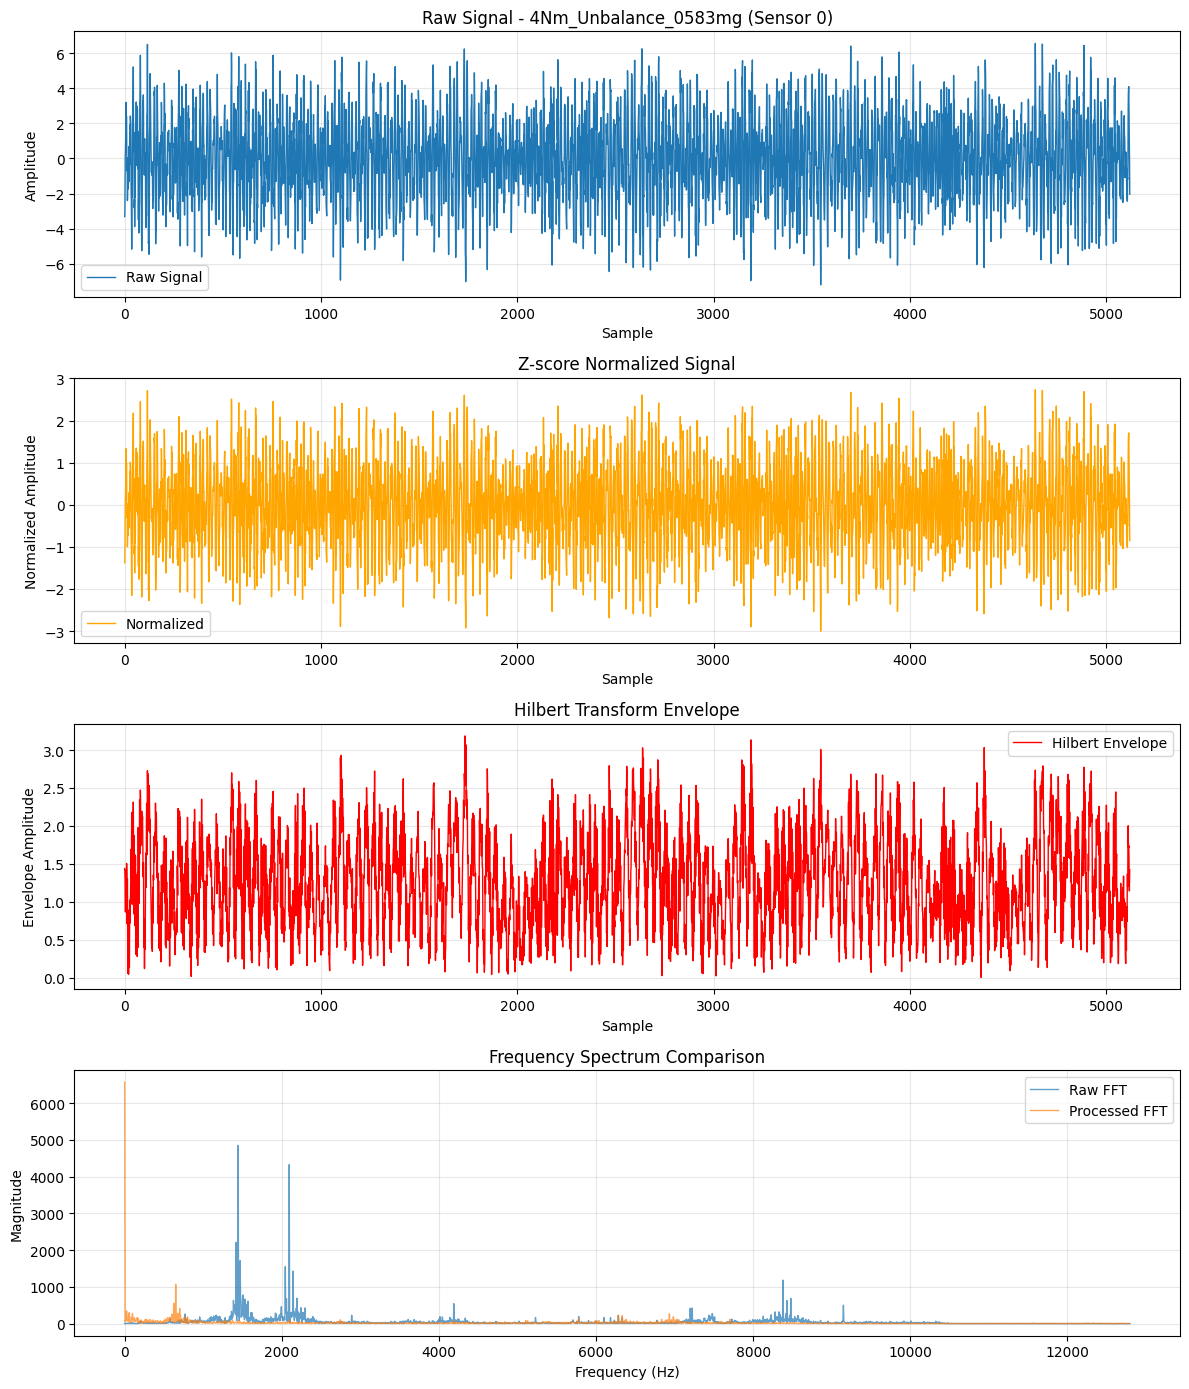

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import hilbert
from scipy.fftpack import fft

def plot_signal_examples(data_dict, class_labels, sampling_rate, window_size):
    """
    Enhanced function to plot signal examples with proper feature extraction pipeline.
    
    This function demonstrates the complete signal processing pipeline used in extract_features:
    1. Signal segmentation
    2. Z-score normalization per segment
    3. Hilbert transform for vibration sensors (channels 0, 3)
    4. FFT transformation
    5. Comparison of raw vs processed signals
    """
    
    # Calculate frequency array for FFT plots
    freqs = np.fft.fftfreq(window_size, d=1/sampling_rate)[:window_size // 2]
    
    # Create subplots
    fig, axes = plt.subplots(4, 1, figsize=(12, 14))
    
    # Randomly select a class and sensor
    label = class_labels[np.random.randint(0, len(class_labels))]
    data = data_dict[label]
    num_samples, num_sensors = data.shape
    
    # Select a vibration sensor (0 or 3)
    sensor_idx = np.random.choice([0, 3])
    sensor_data = data[:, sensor_idx]
    
    # Select a random segment
    num_segments = num_samples // window_size
    random_idx = np.random.randint(0, num_segments)
    segment = sensor_data[random_idx * window_size:(random_idx + 1) * window_size]
    
    # Apply the same processing pipeline as extract_features
    # 1. Z-score normalization
    segment_mean = np.mean(segment)
    segment_std = np.std(segment)
    if segment_std == 0:
        segment_std = 1e-8
    segment_normalized = (segment - segment_mean) / segment_std
    
    # 2. Hilbert transform (for vibration sensors)
    segment_hilbert = np.abs(hilbert(segment_normalized))
    
    # 3. FFT transformation
    fft_raw = np.abs(fft(segment))[:window_size // 2]
    fft_processed = np.abs(fft(segment_hilbert))[:window_size // 2]
    
    # Plotting
    # Raw Signal
    axes[0].plot(segment, label="Raw Signal", linewidth=1)
    axes[0].set_title(f"Raw Signal - {label} (Sensor {sensor_idx})")
    axes[0].set_xlabel("Sample")
    axes[0].set_ylabel("Amplitude")
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Normalized Signal
    axes[1].plot(segment_normalized, label="Normalized", color='orange', linewidth=1)
    axes[1].set_title("Z-score Normalized Signal")
    axes[1].set_xlabel("Sample")
    axes[1].set_ylabel("Normalized Amplitude")
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    # Hilbert Transform Envelope
    axes[2].plot(segment_hilbert, label="Hilbert Envelope", color='red', linewidth=1)
    axes[2].set_title("Hilbert Transform Envelope")
    axes[2].set_xlabel("Sample")
    axes[2].set_ylabel("Envelope Amplitude")
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)
    
    # FFT Comparison
    axes[3].plot(freqs, fft_raw, label="Raw FFT", alpha=0.7, linewidth=1)
    axes[3].plot(freqs, fft_processed, label="Processed FFT", alpha=0.7, linewidth=1)
    axes[3].set_title("Frequency Spectrum Comparison")
    axes[3].set_xlabel("Frequency (Hz)")
    axes[3].set_ylabel("Magnitude")
    axes[3].legend()
    axes[3].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Call the function
plot_signal_examples(vibration_data, class_labels, sampling_rate, window_size)


# 1D CNN Model


## General Model (Visualization)
Implemented with Tensorflow Keras. Three main Convolution blocks are employed. The backbone model is shown below

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, BatchNormalization, ReLU, MaxPooling1D, GlobalAveragePooling1D, Dense

# Define input shape
input_shape = (int(2560/decimation_factor), 1)  # (features, channels)

# Build the model
def build_model(input_shape, num_classes=5):
    model = Sequential([
        # Conv Block 1
        Conv1D(filters=32, kernel_size=33, strides=6, padding='same', input_shape=input_shape),
        BatchNormalization(),
        ReLU(),
        MaxPooling1D(pool_size=3, strides=3, padding='same'),
        
        # Conv Block 2
        Conv1D(filters=64, kernel_size=9, strides=3, padding='same'),
        BatchNormalization(),
        ReLU(),
        MaxPooling1D(pool_size=3, strides=3, padding='same'),
        
        # Conv Block 3
        Conv1D(filters=128, kernel_size=3, strides=1, padding='same'),
        BatchNormalization(),
        ReLU(),
        MaxPooling1D(pool_size=2, strides=2, padding='same'),

        # Adaptive Pooling (Global Average Pooling for output size 128)
        GlobalAveragePooling1D(),  # Adaptive pooling to fixed size 128

        # Fully Connected Layer
        Dense(100, activation='relu'),

        # Output Layer (Change units and activation based on your task)
        Dense(num_classes, activation='softmax')  # Adjust for number of classes
    ])
    
    return model

# Build the model
model = build_model(input_shape, num_classes=len(class_labels))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 427, 32)           1088      
                                                                 
 batch_normalization (BatchN  (None, 427, 32)          128       
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 427, 32)           0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 143, 32)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 48, 64)            18496     
                                                                 
 batch_normalization_1 (Batc  (None, 48, 64)           2

## All Domain Analysis



ANALYZING DOMAIN: 0Nm
Extracting features for 0Nm...
Starting vectorized feature extraction...
Processing 0Nm_Normal (1/5)...
Processing 0Nm_BPFI_03 (2/5)...
Processing 0Nm_BPFO_03 (3/5)...
Processing 0Nm_Misalign_01 (4/5)...
Processing 0Nm_Unbalance_0583mg (5/5)...
Feature extraction completed in 1.72 seconds
Extracted 6000 samples with 2560 features each
X shape: (6000, 2560, 1), Y shape: (6000, 5)

Fold 1/5
Epoch 1/100
150/150 [==============================] - 2s 10ms/step - loss: 0.4430 - accuracy: 0.8135 - val_loss: 0.2269 - val_accuracy: 0.8808
Epoch 2/100
150/150 [==============================] - 1s 7ms/step - loss: 0.1214 - accuracy: 0.9444 - val_loss: 0.1192 - val_accuracy: 0.9550
Epoch 3/100
150/150 [==============================] - 1s 8ms/step - loss: 0.0824 - accuracy: 0.9646 - val_loss: 0.0819 - val_accuracy: 0.9667
Epoch 4/100
150/150 [==============================] - 1s 7ms/step - loss: 0.0433 - accuracy: 0.9860 - val_loss: 0.2438 - val_accuracy: 0.9225
Epoch 5/100


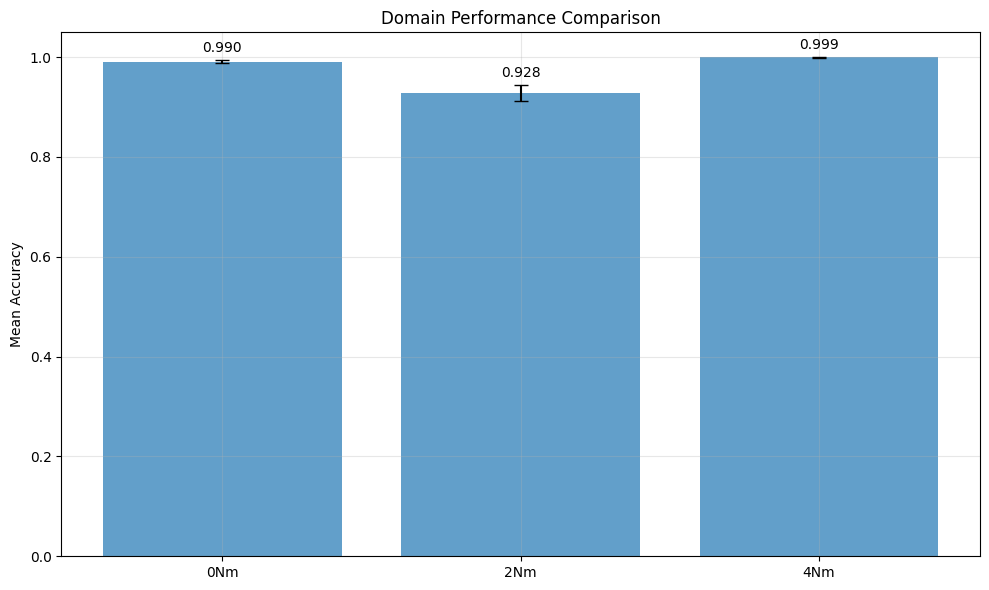


Overall summary saved to: ../Models/overall_summary
Domain comparison summary:
  Domain Mean Accuracy Std Accuracy Best Fold Worst Fold
0    0Nm        0.9903       0.0030    0.9950     0.9867
1    2Nm        0.9282       0.0155    0.9492     0.9075
2    4Nm        0.9993       0.0003    1.0000     0.9992


In [16]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.signal import hilbert
from scipy.fftpack import fft
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.callbacks import EarlyStopping
import time
import json

def run_domain_analysis(domain_name, vibration_data_domain, class_labels_domain, 
                       sampling_rate, window_size, decimation_factor, k_folds=5):
    """
    Run complete analysis for a single domain.
    """
    
    print(f"\n{'='*60}")
    print(f"ANALYZING DOMAIN: {domain_name}")
    print(f"{'='*60}")
    
    # Create directory for this domain
    save_dir = f"../Models/domain_{domain_name}"
    os.makedirs(save_dir, exist_ok=True)
    
    # Parameters
    input_shape = (int(2560/decimation_factor), 1)
    
    # Extract features for this domain
    print(f"Extracting features for {domain_name}...")
    X, Y = extract_features(vibration_data_domain, class_labels_domain)
    print(f"X shape: {X.shape}, Y shape: {Y.shape}")
    
    # Define k-Fold
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
    
    # Store metrics
    all_reports = []
    all_accuracies = []
    model_paths = []
    
    for fold, (train_idx, test_idx) in enumerate(kf.split(X)):
        print(f"\nFold {fold + 1}/{k_folds}")
        
        # Split data for this fold
        X_train, X_test = X[train_idx], X[test_idx]
        Y_train, Y_test = Y[train_idx], Y[test_idx]
        
        # Build the model
        model = build_model(input_shape, num_classes=len(class_labels_domain))
        
        early_stopping = EarlyStopping(
            monitor='val_loss',
            patience=8,
            restore_best_weights=True
        )
        
        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        
        # Train model
        history = model.fit(X_train, Y_train, epochs=100, batch_size=32, 
                          verbose=1, validation_data=(X_test, Y_test), 
                          callbacks=[early_stopping])
        
        # Save model
        model_path = os.path.join(save_dir, f"model_{domain_name}_fold_{fold+1}.h5")
        model.save(model_path)
        model_paths.append(model_path)
        print(f"Saved model: {model_path}")
        
        # Predict and evaluate
        y_pred = np.argmax(model.predict(X_test), axis=1)
        y_true = np.argmax(Y_test, axis=1)
        
        # Compute accuracy
        accuracy = np.mean(y_pred == y_true)
        all_accuracies.append(accuracy)
        
        # Compute confusion matrix
        cm = confusion_matrix(y_true, y_pred)
        cm_percentage = cm.astype('float') / cm.sum(axis=1, keepdims=True) * 100
        
        # Plot and save confusion matrix
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm_percentage, annot=True, fmt=".2f", cmap="Blues",
                   xticklabels=class_labels_domain, yticklabels=class_labels_domain)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title(f"Confusion Matrix - {domain_name} (Fold {fold+1})")
        
        cm_filename = os.path.join(save_dir, f"confusion_matrix_{domain_name}_fold_{fold+1}.png")
        plt.savefig(cm_filename, dpi=300, bbox_inches='tight')
        plt.close()
        
        # Store classification report with proper handling
        # Use target_names to ensure proper class names in report
        report = classification_report(y_true, y_pred, 
                                     target_names=class_labels_domain,
                                     output_dict=True, 
                                     zero_division=0)
        all_reports.append(report)
    
    # Calculate and save final results with proper error handling
    mean_accuracy = np.mean(all_accuracies)
    std_accuracy = np.std(all_accuracies)
    
    # Create summary report with safe access to metrics
    summary_data = []
    metrics = ['precision', 'recall', 'f1-score']
    
    for label in class_labels_domain:  # Use actual class names, not indices
        row = []
        for metric in metrics:
            values = []
            for report in all_reports:
                # Access by actual class name
                if label in report and metric in report[label]:
                    values.append(report[label][metric])
                else:
                    values.append(0.0)  # Default value for missing metrics
            
            mean_val = np.mean(values)
            std_val = np.std(values)
            row.append(f"{mean_val:.4f} ± {std_val:.4f}")
        
        # Add support with safe access
        support_vals = []
        for report in all_reports:
            if label in report and 'support' in report[label]:
                support_vals.append(report[label]['support'])
            else:
                support_vals.append(0)
        
        support_mean = int(np.mean(support_vals))
        row.append(support_mean)
        summary_data.append(row)
    
    # Create final summary DataFrame
    final_report_df = pd.DataFrame(summary_data, 
                                  columns=['Precision', 'Recall', 'F1-score', 'Support'], 
                                  index=class_labels_domain)
    
    # Save results
    final_report_csv = os.path.join(save_dir, f"final_report_{domain_name}.csv")
    final_report_df.to_csv(final_report_csv)
    
    # Save accuracy summary
    accuracy_summary = {
        'domain': domain_name,
        'mean_accuracy': mean_accuracy,
        'std_accuracy': std_accuracy,
        'fold_accuracies': all_accuracies,
        'model_paths': model_paths
    }
    
    accuracy_file = os.path.join(save_dir, f"accuracy_summary_{domain_name}.json")
    with open(accuracy_file, 'w') as f:
        json.dump(accuracy_summary, f, indent=2)
    
    print(f"\nDomain {domain_name} Results:")
    print(f"Mean Accuracy: {mean_accuracy:.4f} ± {std_accuracy:.4f}")
    print(f"Results saved to: {save_dir}")
    
    return accuracy_summary

def run_all_domains_analysis():
    """
    Run analysis for all three domains automatically.
    """
    # Domain configurations
    domains = [
        {
            'name': '0Nm',
            'data': vibration_data0,
            'labels': class_labels0
        },
        {
            'name': '2Nm', 
            'data': vibration_data1,
            'labels': class_labels1
        },
        {
            'name': '4Nm',
            'data': vibration_data2, 
            'labels': class_labels2
        }
    ]
    
    all_results = {}
    
    for domain in domains:
        try:
            results = run_domain_analysis(
                domain_name=domain['name'],
                vibration_data_domain=domain['data'],
                class_labels_domain=domain['labels'],
                sampling_rate=sampling_rate,
                window_size=window_size,
                decimation_factor=decimation_factor
            )
            all_results[domain['name']] = results
        except Exception as e:
            print(f"Error processing domain {domain['name']}: {str(e)}")
            continue
    
    # Create overall summary
    if all_results:
        create_overall_summary(all_results)
    
    return all_results

def create_overall_summary(all_results):
    """
    Create a summary comparing all domains.
    """
    summary_data = []
    for domain_name, results in all_results.items():
        summary_data.append({
            'Domain': domain_name,
            'Mean Accuracy': f"{results['mean_accuracy']:.4f}",
            'Std Accuracy': f"{results['std_accuracy']:.4f}",
            'Best Fold': f"{max(results['fold_accuracies']):.4f}",
            'Worst Fold': f"{min(results['fold_accuracies']):.4f}"
        })
    
    summary_df = pd.DataFrame(summary_data)
    
    # Save overall summary
    overall_dir = "../Models/overall_summary"
    os.makedirs(overall_dir, exist_ok=True)
    
    summary_file = os.path.join(overall_dir, "domain_comparison_summary.csv")
    summary_df.to_csv(summary_file, index=False)
    
    # Create comparison plot
    plt.figure(figsize=(10, 6))
    domains = list(all_results.keys())
    accuracies = [all_results[d]['mean_accuracy'] for d in domains]
    stds = [all_results[d]['std_accuracy'] for d in domains]
    
    plt.bar(domains, accuracies, yerr=stds, capsize=5, alpha=0.7)
    plt.ylabel('Mean Accuracy')
    plt.title('Domain Performance Comparison')
    plt.grid(True, alpha=0.3)
    
    for i, (domain, acc) in enumerate(zip(domains, accuracies)):
        plt.text(i, acc + stds[i] + 0.01, f'{acc:.3f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.savefig(os.path.join(overall_dir, "domain_comparison.png"), dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"\nOverall summary saved to: {overall_dir}")
    print(f"Domain comparison summary:\n{summary_df}")


# Run the complete analysis
if __name__ == "__main__":
    all_results = run_all_domains_analysis()

## Measure Inference time

The model intended to run in real-time. Measuring the time it gets to make an inference is crucial for this statement.

In [6]:
import time

# Example input tensor (batch_size=1, sequence_length=1024, channels=1)
input_data = np.random.randn(4,  int(5120/decimation_factor), 1).astype(np.float32)

# Warm-up run (to avoid initial overhead)
_ = model.predict(input_data)

# Measure inference time
num_runs = 100
start_time = time.time()
for _ in range(num_runs):
    _ = model.predict(input_data)
end_time = time.time()

# Compute average inference time per run (in milliseconds)
avg_inference_time = (end_time - start_time) / num_runs * 1000
print(f"Average Inference Time: {avg_inference_time:.3f} ms")

1/1 [==============================] - 0s 20ms/step
Average Inference Time: 50.733 ms


## MultiDomain Model


Preparing data for fault classification across domains...
Starting vectorized feature extraction...
Processing 0Nm_Normal (1/5)...
Processing 0Nm_BPFI_03 (2/5)...
Processing 0Nm_BPFO_03 (3/5)...
Processing 0Nm_Misalign_01 (4/5)...
Processing 0Nm_Unbalance_0583mg (5/5)...
Feature extraction completed in 1.69 seconds
Extracted 6000 samples with 2560 features each
Starting vectorized feature extraction...
Processing 2Nm_Normal (1/5)...
Processing 2Nm_BPFI_03 (2/5)...
Processing 2Nm_BPFO_03 (3/5)...
Processing 2Nm_Misalign_01 (4/5)...
Processing 2Nm_Unbalance_0583mg (5/5)...
Feature extraction completed in 1.69 seconds
Extracted 6000 samples with 2560 features each
Starting vectorized feature extraction...
Processing 4Nm_Normal (1/5)...
Processing 4Nm_BPFI_03 (2/5)...
Processing 4Nm_BPFO_03 (3/5)...
Processing 4Nm_Misalign_01 (4/5)...
Processing 4Nm_Unbalance_0583mg (5/5)...
Feature extraction completed in 1.65 seconds
Extracted 6000 samples with 2560 features each
Combined dataset: 18000 

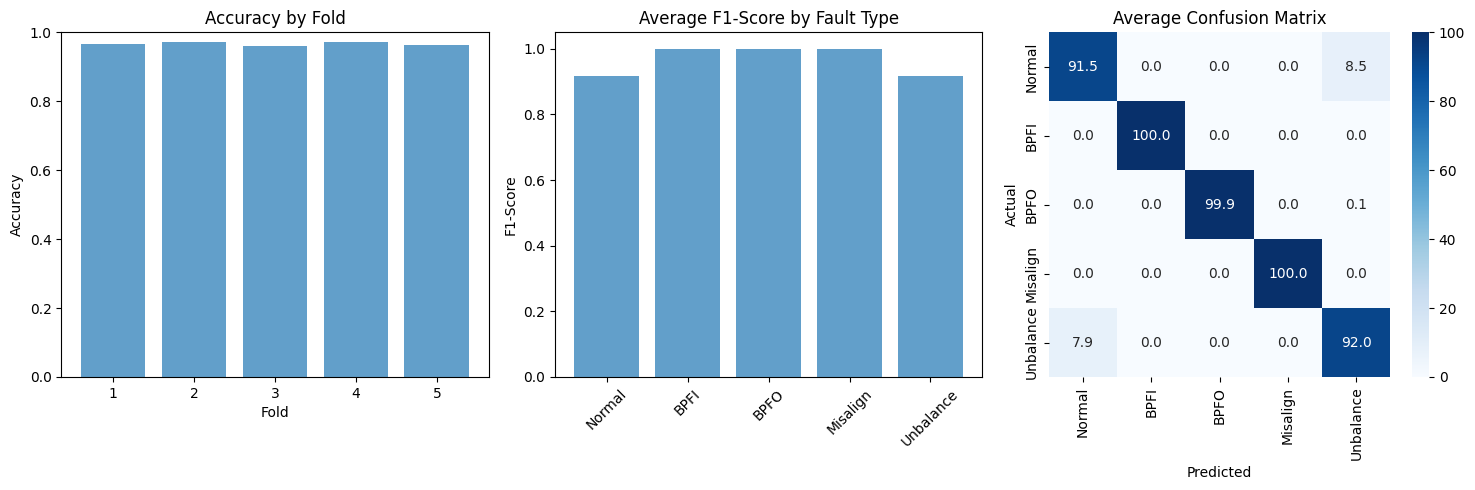


Results saved. Mean accuracy: 0.9667 ± 0.0043


In [24]:
# =============================================================================
# FAULT CLASSIFICATION ACROSS MULTIPLE DOMAINS
# =============================================================================

# 1. Data Preparation
print("Preparing data for fault classification across domains...")

# Extract features for all domains
X0, Y0 = extract_features(vibration_data0, class_labels0)
X1, Y1 = extract_features(vibration_data1, class_labels1)
X2, Y2 = extract_features(vibration_data2, class_labels2)

# Create fault type mapping
fault_mapping = {
    'Normal': 0, 'BPFI_03': 1, 'BPFO_03': 2, 
    'Misalign_01': 3, 'Unbalance_0583mg': 4
}

# Convert domain-specific labels to fault-only labels
def convert_labels(Y_domain, class_labels):
    fault_labels = []
    for i, label in enumerate(class_labels):
        fault_type = label.split('_', 1)[1]
        fault_idx = fault_mapping[fault_type]
        fault_labels.extend([fault_idx] * int(np.sum(Y_domain[:, i])))
    return np.array(fault_labels)

fault_labels_0 = convert_labels(Y0, class_labels0)
fault_labels_1 = convert_labels(Y1, class_labels1)
fault_labels_2 = convert_labels(Y2, class_labels2)

# Combine all data
X_all = np.vstack([X0, X1, X2])
Y_fault_all = tf.keras.utils.to_categorical(
    np.concatenate([fault_labels_0, fault_labels_1, fault_labels_2]), 
    num_classes=5
)

print(f"Combined dataset: {X_all.shape[0]} samples")
print(f"Fault distribution: {np.sum(Y_fault_all, axis=0)}")

# 2. Model Training with K-Fold Cross-Validation
print("\nTraining fault classification model with 5-fold cross-validation...")

k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
input_shape = (int(2560/decimation_factor), 1)
fault_names = ['Normal', 'BPFI', 'BPFO', 'Misalign', 'Unbalance']

# Store results
all_accuracies = []
all_reports = []
all_confusion_matrices = []

for fold, (train_idx, test_idx) in enumerate(kf.split(X_all)):
    print(f"\nFold {fold + 1}/{k_folds}")
    
    # Split data
    X_train, X_test = X_all[train_idx], X_all[test_idx]
    Y_train, Y_test = Y_fault_all[train_idx], Y_fault_all[test_idx]
    
    # Build and train model
    model = build_model(input_shape, num_classes=5)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    history = model.fit(X_train, Y_train, epochs=100, batch_size=32, 
                       validation_data=(X_test, Y_test), callbacks=[early_stopping])
    
    # Evaluate
    y_pred = np.argmax(model.predict(X_test), axis=1)
    y_true = np.argmax(Y_test, axis=1)
    
    accuracy = np.mean(y_pred == y_true)
    all_accuracies.append(accuracy)
    
    # Store results
    cm = confusion_matrix(y_true, y_pred)
    all_confusion_matrices.append(cm)
    
    report = classification_report(y_true, y_pred, target_names=fault_names, output_dict=True)
    all_reports.append(report)
    
    print(f"Fold {fold+1} Accuracy: {accuracy:.4f}")

# 3. Results Analysis
print(f"\n{'='*60}")
print("RESULTS SUMMARY")
print(f"{'='*60}")

mean_accuracy = np.mean(all_accuracies)
std_accuracy = np.std(all_accuracies)
print(f"Mean Accuracy: {mean_accuracy:.4f} ± {std_accuracy:.4f}")
print(f"Individual fold accuracies: {[f'{acc:.4f}' for acc in all_accuracies]}")

# Calculate average metrics across folds
avg_precision = []
avg_recall = []
avg_f1 = []

for fault_name in fault_names:
    precisions = [report[fault_name]['precision'] for report in all_reports]
    recalls = [report[fault_name]['recall'] for report in all_reports]
    f1s = [report[fault_name]['f1-score'] for report in all_reports]
    
    avg_precision.append(np.mean(precisions))
    avg_recall.append(np.mean(recalls))
    avg_f1.append(np.mean(f1s))

# 4. Visualization
plt.figure(figsize=(15, 5))

# Accuracy by fold
plt.subplot(1, 3, 1)
plt.bar(range(1, k_folds+1), all_accuracies, alpha=0.7)
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.title('Accuracy by Fold')
plt.ylim(0, 1)

# F1-score by fault type
plt.subplot(1, 3, 2)
plt.bar(fault_names, avg_f1, alpha=0.7)
plt.ylabel('F1-Score')
plt.title('Average F1-Score by Fault Type')
plt.xticks(rotation=45)

# Confusion matrix (average across folds)
plt.subplot(1, 3, 3)
avg_cm = np.mean(all_confusion_matrices, axis=0)
avg_cm_percentage = avg_cm / avg_cm.sum(axis=1, keepdims=True) * 100
sns.heatmap(avg_cm_percentage, annot=True, fmt=".1f", cmap="Blues",
           xticklabels=fault_names, yticklabels=fault_names)
plt.title('Average Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.tight_layout()
plt.show()

# 5. Save Results
results = {
    'mean_accuracy': mean_accuracy,
    'std_accuracy': std_accuracy,
    'fold_accuracies': all_accuracies,
    'fault_precision': avg_precision,
    'fault_recall': avg_recall,
    'fault_f1': avg_f1
}

print(f"\nResults saved. Mean accuracy: {mean_accuracy:.4f} ± {std_accuracy:.4f}")